# Change audio by detecting onset 
This notebook contains a method that could change the target video sound with a given audio.

### Load packages

In [118]:
import IPython
import os
import numpy as np
from moviepy.editor import *
import librosa
from IPython.display import Audio
from IPython.display import Video

In [119]:
# Read videos
origin_video_path = 'data/target.mp4'
conditional_video_path = 'data/conditional.mp4'
# conditional_video_path = 'data/dog_bark.mp4'

ori_videoclip = VideoFileClip(origin_video_path)
con_videoclip = VideoFileClip(conditional_video_path)


In [120]:
Video(origin_video_path, width=640)

In [121]:
Video(conditional_video_path, width=640)

In [122]:
# get the audio track from video
ori_audioclip = ori_videoclip.audio
ori_audio, ori_sr = ori_audioclip.to_soundarray(), ori_audioclip.fps
con_audioclip = con_videoclip.audio
con_audio, con_sr = con_audioclip.to_soundarray(), con_audioclip.fps

ori_audio = ori_audio.mean(-1)
con_audio = con_audio.mean(-1)

target_sr = 22050
ori_audio = librosa.resample(ori_audio, orig_sr=ori_sr, target_sr=target_sr)
con_audio = librosa.resample(con_audio, orig_sr=con_sr, target_sr=target_sr)

ori_sr, con_sr = target_sr, target_sr

In [123]:
def detect_onset_of_audio(audio, sample_rate):
    onsets = librosa.onset.onset_detect(
        y=audio, sr=sample_rate, units='samples', delta=0.3)
    return onsets


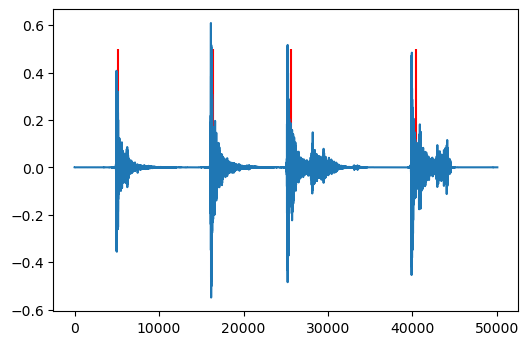

In [124]:
from matplotlib import pyplot as plt
onsets = detect_onset_of_audio(ori_audio, ori_sr)
plt.figure(dpi=100)

time = np.arange(ori_audio.shape[0])
plt.plot(time, ori_audio)
plt.vlines(onsets, 0, ymax=0.5, colors='r')
plt.show()


### Method
The baseline is quite simple, and it has several steps:
- Take the original waveform (encoded and decoded by our codebook) and detect the onsets to determine the timestamp of sound events
- (Optional) Assume we don't have original waveform, we can use Andrew's great hit model to predict sound from frames and detect onsets from it.
- Detect onsets of conditional waveform (encoded and decoded by our codebook) and clip single onset event from them as sound candicates
- For each onset of original waveform, replace with conditional onset event randomly and then generate sound

In [125]:
def get_onset_audio_range(audio, onsets, i):
    if i == 0:
        prev_offset = int(onsets[i] // 3)
    else:
        prev_offset = int((onsets[i] - onsets[i - 1]) // 3)

    if i == onsets.shape[0] - 1:
        post_offset = int((audio.shape[0] - onsets[i]) // 4 * 2)
    else:
        post_offset = int((onsets[i + 1] - onsets[i]) // 4 * 2)
    return prev_offset, post_offset


In [126]:
ori_onsets = detect_onset_of_audio(ori_audio, ori_sr)
con_onsets = detect_onset_of_audio(con_audio, con_sr)

np.random.seed(2022)
gen_audio = np.zeros_like(ori_audio)
for i in range(ori_onsets.shape[0]):
    prev_offset, post_offset = get_onset_audio_range(ori_audio, ori_onsets, i)
    j = np.random.choice(con_onsets.shape[0])
    prev_offset_con, post_offset_con = get_onset_audio_range(con_audio, con_onsets, j)
    prev_offset = min(prev_offset, prev_offset_con)
    post_offset = min(post_offset, post_offset_con)
    gen_audio[ori_onsets[i] - prev_offset: ori_onsets[i] + post_offset] = con_audio[con_onsets[j] - prev_offset: con_onsets[j] + post_offset]



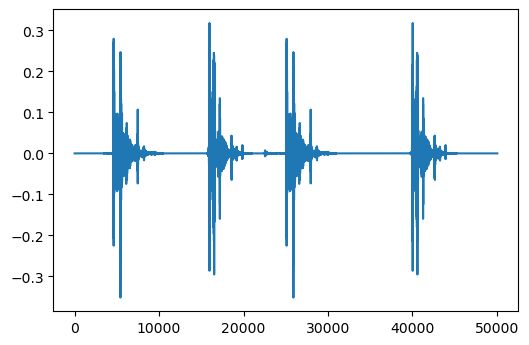

In [127]:
from matplotlib import pyplot as plt
plt.figure(dpi=100)
time = np.arange(gen_audio.shape[0])
plt.plot(time, gen_audio)
plt.show()


In [128]:
# save audio
import soundfile as sf
sf.write('data/gen_audio.wav', gen_audio, ori_sr)


In [129]:
gen_audioclip = AudioFileClip("data/gen_audio.wav")
gen_videoclip = ori_videoclip.set_audio(gen_audioclip)
gen_videoclip.write_videofile('data/generate.mp4')


t:   0%|          | 0/49 [00:00<?, ?it/s, now=None]    

Moviepy - Building video data/generate.mp4.
MoviePy - Writing audio in generateTEMP_MPY_wvf_snd.mp3
MoviePy - Done.
Moviepy - Writing video data/generate.mp4



Moviepy - Done !
Moviepy - video ready data/generate.mp4


In [130]:
Video('data/generate.mp4', width=640)
